# **IMPORTS**

In [1]:
import numpy as np 
import pandas as pd 
import torch 
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame
from catboost import CatBoostClassifier
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import wandb 
from torch.utils.data import Dataset, DataLoader

!pip install peft

from peft import IA3Config, get_peft_model, TaskType, LoraConfig


!python -m spacy download ru_core_news_sm

from transformers import Trainer, TrainingArguments, AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from datasets import Dataset
import spacy

import warnings
warnings.simplefilter("ignore")

nltk.download('wordnet')

from pathlib import Path

root_to_data = Path('/kaggle/input/secondpilot-dataset/train_SecondPilot')

plt.style.use('ggplot')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 1.9 MB/s eta 0:00:00 0:00:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 63.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 847.6 kB/s eta 0:00:00--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 27.7 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')


2024-04-28 06:01:36.604711: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-28 06:01:36.604835: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-28 06:01:36.712896: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# **DATA**

Файл ***answer_class.csv*** - отображение ответа в число.

In [2]:
answer_class_df = pd.read_csv(f'{root_to_data}/answer_class.csv')
print(answer_class_df.shape, '\n', answer_class_df.head(-1))

(30, 2) 
     answer_class                                             Answer
0              0  После успешного прохождения выпускных испытани...
1              1  Чтобы получить итоговый документ, нужно сдать ...
2              2  Можем его выдать, если вы:\n\nоплатили обучени...
3              3  Можем его выдать, если вы:\n\nоплатили обучени...
4              4  Диплом или удостоверение отправим бесплатно По...
5              5  Обычно уроки проходят на одной из платформ — Z...
6              6  Курсы проходят в порядке, указанном в разделе ...
7              7  Мы используем разные форматы обучения. Вас жду...
8              8  Сейчас в GeekBrains около 40 форматов занятий....
9              9  Если вы не смогли присутствовать на вебинаре, ...
10            10  Задания, которые требуют проверки, оценивает п...
11            11  Мы можем перевести вас в другую группу в рамка...
12            12  Задание найдёте внутри курса, во вкладке «Прак...
13            13  Длительность програм

Файл ***train_data.csv*** - примеры вопросов студентов и соответствующих ответов в виде чисел.

In [3]:
train_data = pd.read_csv(f'{root_to_data}/train_data.csv')
print(train_data.shape, '\n', train_data.head(10))

(69, 3) 
                                             Question  \
0  Что делать, если я хочу изменить группу или сп...   
1  Из чего состоит основное обучение в личном каб...   
2  Что входит в программу помощи с трудоустройств...   
3   Подскажите расписание каникул в 2024, пожалуйста   
4  Какие инструменты и ресурсы вы предоставляете ...   
5                  Кто проверяет мои сданные работы?   
6                             Когда я получу диплом?   
7       Какая последовательность курсов в программе?   
8  Где можно найти информацию о расписании курсов...   
9  Когда нужно было оплатить обучение, чтобы полу...   

                   Category  answer_class  
0  Перевод/ запись в группу            11  
1                    Портал            15  
2           Трудоустройство            27  
3                Расписание            21  
4           Трудоустройство            25  
5                    Оценки            10  
6                 Документы             2  
7        Организация 

In [4]:
train_data_merged = train_data.merge(answer_class_df, on='answer_class')
print(train_data_merged.shape, '\n', train_data_merged.head(10))

(69, 4) 
                                             Question  \
0  Что делать, если я хочу изменить группу или сп...   
1  Из чего состоит основное обучение в личном каб...   
2  Что входит в программу помощи с трудоустройств...   
3   Подскажите расписание каникул в 2024, пожалуйста   
4  Какие инструменты и ресурсы вы предоставляете ...   
5                  Кто проверяет мои сданные работы?   
6                             Когда я получу диплом?   
7       Какая последовательность курсов в программе?   
8  Где можно найти информацию о расписании курсов...   
9  Когда нужно было оплатить обучение, чтобы полу...   

                   Category  answer_class  \
0  Перевод/ запись в группу            11   
1                    Портал            15   
2           Трудоустройство            27   
3                Расписание            21   
4           Трудоустройство            25   
5                    Оценки            10   
6                 Документы             2   
7        Орга

Файл ***sample_submission.csv*** - пример файла ответа для проверки метрик. 

In [5]:
sample_submission = pd.read_csv(f'{root_to_data}/sample_submission.csv')
print(sample_submission.shape, '\n', sample_submission.head(-1))

(129, 2) 
                     hash  answer_class
0   -5619544560237527616             0
1   -3561821032679218920             0
2    5542832344828775180             0
3     374064106604922467             0
4    7767274468230729980             0
..                   ...           ...
123 -3263069976611422720             0
124 -7999382456339933392             0
125  4313314577654585140             0
126  7491810572860539119             0
127  3307781612299318449             0

[128 rows x 2 columns]


У нас не очень много тренировочных данных, поэтому сделаем аугментацию

In [6]:
import pandas as pd
'''
Добавим файл с аугментацией данных
'''
aug_data = pd.read_json('/kaggle/input/augmented-data/augmented_data.jsonl', lines=True)
aug_sents = aug_data.iloc[0].aug
aug_data = aug_data.rename(columns={'original': 'Question'})
print(len(aug_sents), '\n', aug_sents[0])

69 
 ['Что, если я хочу изменить группу или специализацию во время обучения?', 'Что, если бы я хотел изменить группу или специализацию на протяжении всего курса?', 'Что я могу сделать, если я хочу изменить свою группу или свою специализацию в школе?', 'Что, если я хочу изменить группу или специализацию во время обучения?', 'Что делать, если я хочу изменить группу или специализацию во время учебы?', 'Что делать, если я хочу изменить группу или специализацию во время обучения?']


In [7]:
aug_data = pd.DataFrame(columns=['Questions_aug', 'answer_class'])

dfs = []

for i in range(len(aug_sents)):
    for j in range(len(aug_sents[i])):
        # Создаем DataFrame для каждой строки
        row_to_append = pd.DataFrame({
            'Questions_aug': [aug_sents[i][j]],
            'answer_class': [train_data_merged['answer_class'][i]]
        })

        dfs.append(row_to_append)

aug_data = pd.concat(dfs, ignore_index=True)

print(aug_data.shape)
print(aug_data.head(-1))

(414, 2)
                                         Questions_aug  answer_class
0    Что, если я хочу изменить группу или специализ...            11
1    Что, если бы я хотел изменить группу или специ...            11
2    Что я могу сделать, если я хочу изменить свою ...            11
3    Что, если я хочу изменить группу или специализ...            11
4    Что делать, если я хочу изменить группу или сп...            11
..                                                 ...           ...
408                         Какой формат моего класса?             8
409               Каков формат урока в моей программе?             8
410              Каков формат уроков в моей программе?             8
411                         Какой формат моего класса?             8
412                       Каков формат моей программы?             8

[413 rows x 2 columns]


In [8]:
train_data_merged.head(3)

,Question,Category,answer_class,Answer
0,"Что делать, если я хочу изменить группу или сп...",Перевод/ запись в группу,11,Мы можем перевести вас в другую группу в рамка...
1,Из чего состоит основное обучение в личном каб...,Портал,15,"Подготовка — курсы, которые помогут подготовит..."
2,Что входит в программу помощи с трудоустройств...,Трудоустройство,27,Карьерный план\nПостроите свою стратегию поиск...


In [9]:
train_data_merged = train_data_merged.drop(['Question'], axis=1)
aug_data = aug_data.merge(train_data_merged, on='answer_class')
print(aug_data.shape)
print(aug_data.head(-1))

(1002, 4)
                                          Questions_aug  answer_class  \
0     Что, если я хочу изменить группу или специализ...            11   
1     Что, если я хочу изменить группу или специализ...            11   
2     Что, если я хочу изменить группу или специализ...            11   
3     Что, если бы я хотел изменить группу или специ...            11   
4     Что, если бы я хотел изменить группу или специ...            11   
...                                                 ...           ...   
996                        Каков формат моей программы?             8   
997                        Каков формат моей программы?             8   
998                        Каков формат моей программы?             8   
999             Какой формат уроков для моей программы?             8   
1000            Какой формат уроков для моей программы?             8   

                      Category  \
0     Перевод/ запись в группу   
1     Перевод/ запись в группу   
2     Перев

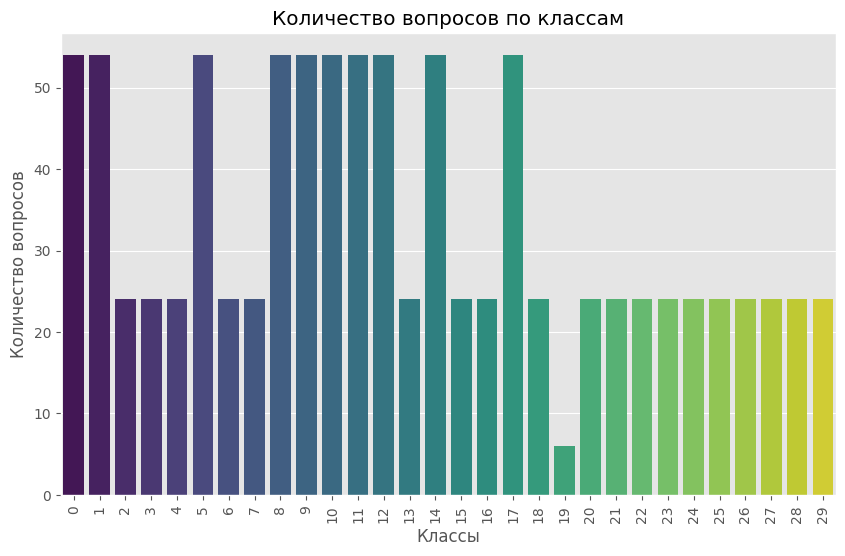

In [10]:
class_counts = aug_data['answer_class'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Количество вопросов по классам')
plt.xlabel('Классы')
plt.ylabel('Количество вопросов')
plt.xticks(rotation=90) 
plt.show()

# **BASELINE решение c помощью TF-IDF**

In [11]:
aug_data['Questions_tokens'] = aug_data['Questions_aug'].apply(word_tokenize)

# # Удаляем стоп-слова и лемматизацию
# lemmatizer = WordNetLemmatizer()
# stop_words = set(stopwords.words('english'))

# def preprocess_tokens(tokens):
#     return [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

# train_data_merged['Question_tokens'] = train_data_merged['Question_tokens'].apply(preprocess_tokens)

#Преобразовываем вопросы в TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(aug_data['Questions_aug'])

In [12]:
label = aug_data['answer_class']
print(aug_data.shape)
print(aug_data.head(-1))

(1002, 5)
                                          Questions_aug  answer_class  \
0     Что, если я хочу изменить группу или специализ...            11   
1     Что, если я хочу изменить группу или специализ...            11   
2     Что, если я хочу изменить группу или специализ...            11   
3     Что, если бы я хотел изменить группу или специ...            11   
4     Что, если бы я хотел изменить группу или специ...            11   
...                                                 ...           ...   
996                        Каков формат моей программы?             8   
997                        Каков формат моей программы?             8   
998                        Каков формат моей программы?             8   
999             Какой формат уроков для моей программы?             8   
1000            Какой формат уроков для моей программы?             8   

                      Category  \
0     Перевод/ запись в группу   
1     Перевод/ запись в группу   
2     Перев

In [13]:
aug_data['Questions_aug'][15]

'Что делать, если я хочу изменить группу или специализацию во время обучения?'

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, label, test_size=0.2, random_state=42, stratify=label)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("\nFirst few rows of X_train:")
print(X_train)
print("\nFirst few rows of X_test:")
print(X_test)
print("\nFirst few rows of y_train:")
print(y_train)
print("\nFirst few rows of y_test:")
print(y_test)

X_train shape: (801, 684)
X_test shape: (201, 684)
y_train shape: (801,)
y_test shape: (201,)

First few rows of X_train:
  (0, 57)	0.5059446418206913
  (0, 151)	0.39844324122748787
  (0, 147)	0.434890080978743
  (0, 237)	0.46254874937218676
  (0, 182)	0.18223815442669822
  (0, 108)	0.25633411954359137
  (0, 74)	0.28855562562971665
  (1, 558)	0.3390826433977895
  (1, 69)	0.3484091482627218
  (1, 135)	0.3484091482627218
  (1, 175)	0.3484091482627218
  (1, 308)	0.32719995393796625
  (1, 629)	0.29840379027617747
  (1, 228)	0.21878208352141496
  (1, 21)	0.30578991399118627
  (1, 246)	0.18901315026710264
  (1, 667)	0.384255751702044
  (2, 475)	0.41826107865522105
  (2, 248)	0.35013413095803136
  (2, 493)	0.4055866631090876
  (2, 119)	0.32622889018599766
  (2, 574)	0.32622889018599766
  (2, 214)	0.30338400688550604
  (2, 182)	0.178300058435253
  (2, 223)	0.29082640449955105
  :	:
  (797, 261)	0.27569188413036244
  (798, 288)	0.4445041106686688
  (798, 381)	0.2940816100574654
  (798, 105)	0.3

FIT

In [15]:
def questions_to_embeddings(dataframe: DataFrame):
    '''
    Преобразоваем вопросы в эмбеддинги
    '''
    model = Word2Vec(sentences=dataframe['Questions_tokens'], vector_size=100, window=5, min_count=1, workers=4)

    X_train_embeddings = []
    for tokens in dataframe['Questions_tokens']:
        embeddings = [model.wv[token] for token in tokens if token in model.wv]
        if embeddings:
            X_train_embeddings.append(sum(embeddings) / len(embeddings))
        else:
            X_train_embeddings.append(np.zeros(model.vector_size))

    X_train_embeddings = np.array(X_train_embeddings)
    print(X_train_embeddings)
    return X_train_embeddings

questions_to_embeddings(aug_data)

[[ 9.8962396e-02  2.2086522e-01 -4.0775292e-02 ... -5.0925631e-02
   2.2997882e-02 -1.1731687e-03]
 [ 9.8962396e-02  2.2086522e-01 -4.0775292e-02 ... -5.0925631e-02
   2.2997882e-02 -1.1731687e-03]
 [ 9.8962396e-02  2.2086522e-01 -4.0775292e-02 ... -5.0925631e-02
   2.2997882e-02 -1.1731687e-03]
 ...
 [ 8.5507073e-02  1.9286363e-01 -3.1596851e-02 ... -4.5855347e-02
   1.9884076e-02  5.2178213e-05]
 [ 8.5507073e-02  1.9286363e-01 -3.1596851e-02 ... -4.5855347e-02
   1.9884076e-02  5.2178213e-05]
 [ 8.5507073e-02  1.9286363e-01 -3.1596851e-02 ... -4.5855347e-02
   1.9884076e-02  5.2178213e-05]]


array([[ 9.8962396e-02,  2.2086522e-01, -4.0775292e-02, ...,
        -5.0925631e-02,  2.2997882e-02, -1.1731687e-03],
       [ 9.8962396e-02,  2.2086522e-01, -4.0775292e-02, ...,
        -5.0925631e-02,  2.2997882e-02, -1.1731687e-03],
       [ 9.8962396e-02,  2.2086522e-01, -4.0775292e-02, ...,
        -5.0925631e-02,  2.2997882e-02, -1.1731687e-03],
       ...,
       [ 8.5507073e-02,  1.9286363e-01, -3.1596851e-02, ...,
        -4.5855347e-02,  1.9884076e-02,  5.2178213e-05],
       [ 8.5507073e-02,  1.9286363e-01, -3.1596851e-02, ...,
        -4.5855347e-02,  1.9884076e-02,  5.2178213e-05],
       [ 8.5507073e-02,  1.9286363e-01, -3.1596851e-02, ...,
        -4.5855347e-02,  1.9884076e-02,  5.2178213e-05]], dtype=float32)

In [16]:
cat_clf = CatBoostClassifier(random_state=0, verbose=0).fit(X_train, y_train)
log_clf = LogisticRegression().fit(X_train, y_train)

In [17]:
y_pred_cat = cat_clf.predict(X_test)
print(f'accuracy on catboost: {accuracy_score(y_pred=y_pred_cat, y_true=y_test)}')

y_pred_log = log_clf.predict(X_test)
print(f'accuracy on log regression: {accuracy_score(y_pred=y_pred_log, y_true=y_test)}')

accuracy on catboost: 1.0
accuracy on log regression: 0.9751243781094527


In [18]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in skf.split(X, label):
    X_train_kfold, X_test_kfold = X[train_index], X[test_index]
    y_train_kfold, y_test_kfold = label[train_index], label[test_index]
    
cat_clf_kfold = CatBoostClassifier(random_state=0, verbose=0).fit(X_train_kfold, y_train_kfold)

y_pred_cat_kfold = cat_clf_kfold.predict(X_test_kfold)
print(f'accuracy on catboost: {accuracy_score(y_pred=y_pred_cat_kfold, y_true=y_test_kfold)}')

accuracy on catboost: 0.985


# **Основное решение с помощью transformers**

In [19]:
# Загрузка и настройка SpaCy для обработки текста
nlp = spacy.load("ru_core_news_sm")

# Загрузка и настройка токенизатора и модели
tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')
model = AutoModelForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# peft_config = LoraConfig(task_type=TaskType.SEQ_CLS, r=8)

# peft_config = IA3Config(
#     task_type=TaskType.SEQ_CLS, target_modules=["query", "key", "output.dense"], feedforward_modules=["output.dense"]
# )
# model = get_peft_model(model, peft_config)

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [20]:
print(f'aug_data: {aug_data.head(3)}')

aug_data:                                        Questions_aug  answer_class  \
0  Что, если я хочу изменить группу или специализ...            11   
1  Что, если я хочу изменить группу или специализ...            11   
2  Что, если я хочу изменить группу или специализ...            11   

                   Category  \
0  Перевод/ запись в группу   
1  Перевод/ запись в группу   
2  Перевод/ запись в группу   

                                              Answer  \
0  Мы можем перевести вас в другую группу в рамка...   
1  Мы можем перевести вас в другую группу в рамка...   
2  Мы можем перевести вас в другую группу в рамка...   

                                    Questions_tokens  
0  [Что, ,, если, я, хочу, изменить, группу, или,...  
1  [Что, ,, если, я, хочу, изменить, группу, или,...  
2  [Что, ,, если, я, хочу, изменить, группу, или,...  


In [21]:
data_with_drops = aug_data.drop(['Category', 'Questions_tokens', 'Answer'], axis=1)
print(f'data_with_drops: {data_with_drops.head(3)}')

data_with_drops:                                        Questions_aug  answer_class
0  Что, если я хочу изменить группу или специализ...            11
1  Что, если я хочу изменить группу или специализ...            11
2  Что, если я хочу изменить группу или специализ...            11


In [27]:
train_data, test_data = train_test_split(data_with_drops, test_size=0.2, random_state=42, stratify=label)
print(f'train_data: {train_data.shape} \n {train_data.head(3)}')
print(f'test_data: {test_data.shape} \n {test_data.head(3)}')

# def encode_examples(df):
#     inputs = tokenizer(df['Questions_aug'].tolist(), padding=True, truncation=True, max_length=512, return_tensors="pt")
#     labels = torch.tensor(df['answer_class'].tolist())
#     inputs.to(device)
#     labels.to(device)
#     return inputs, labels

# # Подготовка обучающих и тестовых данных
# train_inputs, train_labels = encode_examples(train_data)
# test_inputs, test_labels = encode_examples(test_data)
# print(f'train_inputs: {train_inputs}, \n train_labels: {train_labels}')

# 2 пример для датасета
dataset = Dataset.from_pandas(train_data)

def tokenize_and_align_labels(examples):
    '''
    Функция для токенизации и преобразования меток классов
    '''
    max_length = 512 # Выберите подходящее значение для вашего случая
    tokenized_inputs = tokenizer(examples["Questions_aug"], padding="max_length", truncation=True, max_length=max_length)
    tokenized_inputs["labels"] = examples["answer_class"]
    return tokenized_inputs

# Применение функции токенизации к датасету
tokenized_dataset = dataset.map(tokenize_and_align_labels, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns("answer_class")
print(tokenized_dataset)

train_data: (801, 2) 
                                          Questions_aug  answer_class
889        Как вы включите записи о занятиях для меня?            17
405  Могу ли я ожидать, что уроки будут интерактивн...             7
322  Как найти список курсов, которые я должен прох...            14
test_data: (201, 2) 
                                          Questions_aug  answer_class
330     Что связано с подготовкой, прежде всего, в ЛК?            15
742        Где я могу найти записи прошлых веб-сайтов?             9
812  Можно ли получить диплом без предварительной и...             1


Map:   0%|          | 0/801 [00:00<?, ? examples/s]

Dataset({
    features: ['Questions_aug', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 801
})


In [28]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()

AttributeError: 'CustomDataset' object has no attribute '_data'

In [ ]:
from transformers import pipeline

pipe = pipeline("text-classification", model=model, tokenizer=tokenizer)

question = "Какой сегодня день недели?"

# Предсказание класса вопроса
prediction = pipe(question)

# Вывод результата
print(prediction)